Original Series:
ADF Statistic: -2.7863
p-value: 0.0603
❌ Not stationary — differencing needed.


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported inde

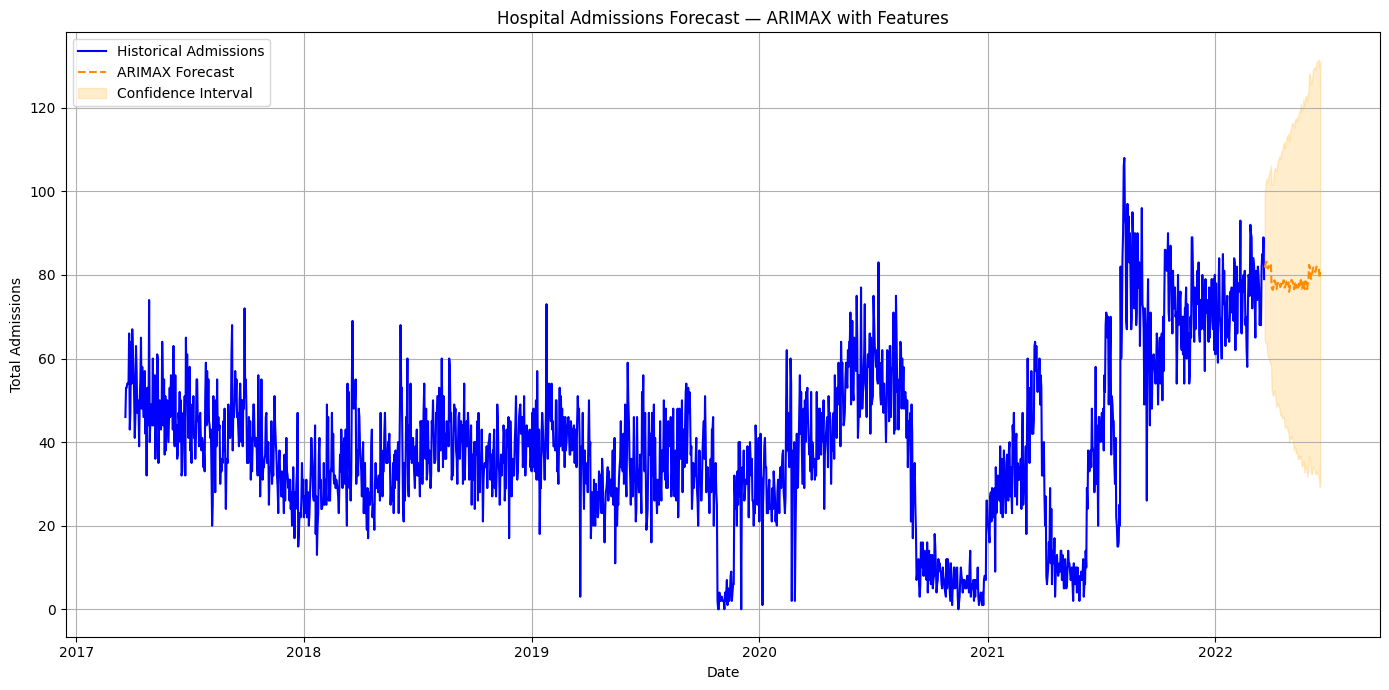


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21                  81.77        64.59        98.95
1820 2022-03-22                  82.28        63.82       100.73
1821 2022-03-23                  83.05        63.86       102.23
1822 2022-03-24                  83.17        63.34       103.01
1823 2022-03-25                  81.69        61.24       102.15
1824 2022-03-26                  81.53        60.47       102.59
1825 2022-03-27                  82.13        60.48       103.77
1826 2022-03-28                  81.86        59.64       104.08
1827 2022-03-29                  82.26        59.49       105.04
1828 2022-03-30                  81.91        58.59       105.23
1829 2022-03-31                  82.35        58.51       106.20
1830 2022-04-01                  77.15        52.78       101.52
1831 2022-04-02                  76.62        51.74       101.49
1832 2022-04-03                  76.44        51.07       101.81
1833 2

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
 
# === Step 1: Load data ===
hospital_data = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv")

hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)
 
# === Step 2: Define target & exogenous variables ===
y = hospital_data['Total_Admissions']
 
exog_vars = [
    'is_weekend', 'season', 'temperature_max', 'temperature_min',
    'temp_range', 'precipitation', 'is_rain',
    'Festival', 'pandemic_flag', 'disaster_flag'
]
exog = hospital_data[exog_vars]
 
# === Step 3: Stationarity check ===
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("✅ Stationary time series.")
    else:
        print("❌ Not stationary — differencing needed.")
 
print("Original Series:")
test_stationarity(y)
 
# === Step 4: Fit ARIMAX Model ===
# ARIMA(p,d,q) — d=1 if not stationary
p, d, q = 1, 1, 1  # Typical starter values
arimax_model = SARIMAX(y, exog=exog, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
arimax_results = arimax_model.fit(disp=False)
 
# === Step 5: Forecasting ===
forecast_steps = 90
 
# Use the last known 90 exogenous rows for prediction — usually you update this for the real world
future_exog = exog.iloc[-forecast_steps:].copy()
 
forecast = arimax_results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
 
# === Step 6: Visualization ===
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Historical Admissions', color='blue')
plt.plot(forecast_index, forecast_mean, label='ARIMAX Forecast', color='darkorange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title('Hospital Admissions Forecast — ARIMAX with Features')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# === Step 7: Print Forecast Table ===
forecast_table = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Admissions': forecast_mean.round(2),
    'Lower_Bound': forecast_ci.iloc[:, 0].round(2),
    'Upper_Bound': forecast_ci.iloc[:, 1].round(2)
})
 
print("\nForecast Preview:")
print(forecast_table.head(15))